<a href="https://colab.research.google.com/github/alinspiron/Fire-and-Smoke-Net/blob/master/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fire and Smoke Detection Using CNN
This project is developed using Blog at Pyimagesearch https://www.pyimagesearch.com/2019/11/18/fire-and-smoke-detection-with-keras-and-deep-learning/
by Adrian Rosebrock on November 18, 2019

It has been modified and updated by me at 28-March-2020


In [0]:
pip uninstall tensorflow

In [0]:
pip install tensorflow==2.1.0

##Import Libraries and Neural Network Model Class

In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.1.0
/device:GPU:0


In [0]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

##Import Data from Google Drive

In [0]:

# initialize the path to the fire and non-fire dataset directories
FIRE_PATH = '/content/drive/My Drive/Colab Notebooks/Robbery_Accident_Fire_Database2/Fire'
NON_FIRE_PATH = '/content/drive/My Drive/Colab Notebooks/spatial_envelope_256x256_static_8outdoorcategories'

# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.75
TEST_SPLIT = 0.25

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-2
BATCH_SIZE = 64
NUM_EPOCHS = 50

# set the path to the serialized model after training
####MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])

# define the path to the output learning rate finder plot and
# training history plot
####LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
####TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

# define the path to the output directory that will store our final
# output with labels/annotations along with the number of iamges to
# sample
####OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50

In [10]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

		# add the image to the data lists
		data.append(image)

	# return the data list as a NumPy array
	return np.array(data, dtype="float32")

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-f", "--lr-find", type=int, default=0,
#	help="whether or not to find optimal learning rate")
#args = vars(ap.parse_args())

# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset( FIRE_PATH)
nonFireData = load_dataset( NON_FIRE_PATH)
print("[INFO] Completed")

[INFO] loading data...
[INFO] Completed


##Preprocessing and Exploring Dataset

In [11]:
print(fireData.shape)
print(nonFireData.shape)

(1315, 128, 128, 3)
(2693, 128, 128, 3)


In [0]:
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])


In [0]:
data /= 255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [26]:
print(data.shape)
print(labels.shape)
print(labels[1:])
print(classTotals)

(4008, 128, 128, 3)
(4008, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[2693. 1315.]


In [0]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size= TEST_SPLIT, random_state=42)

In [57]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(3006, 128, 128, 3)
(3006, 2)
(1002, 128, 128, 3)
(1002, 2)


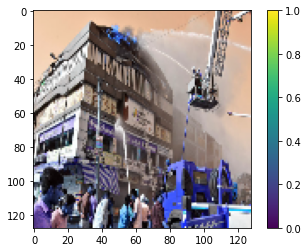

In [54]:
%matplotlib inline
plt.figure()
plt.imshow(trainX[1])
plt.colorbar()
plt.grid(False)
plt.show()

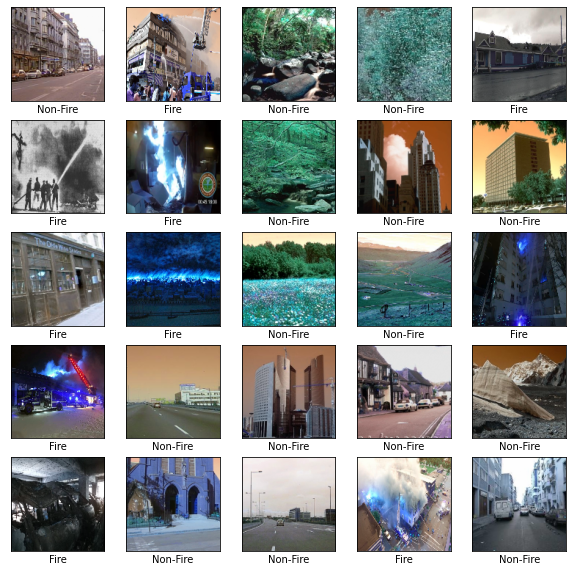

In [58]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    if trainY[i][0] == 1:
      plt.xlabel("Non-Fire")
    else:
      plt.xlabel("Fire")

plt.show()

##Training Model

In [59]:
# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr= INIT_LR, momentum=0.9,
	decay= INIT_LR /  NUM_EPOCHS)
model = FireDetectionNet.build(width=128, height=128, depth=3,
	classes=2)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs

# train the network
print("[INFO] training network...")
H = model.fit_generator(
	aug.flow(trainX, trainY, batch_size= BATCH_SIZE),
	validation_data=(testX, testY),
	steps_per_epoch=trainX.shape[0] //  BATCH_SIZE,
	epochs= NUM_EPOCHS,
	class_weight=classWeight,
	verbose=1)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size= BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names= CLASSES))

# serialize the model to disk
#print("[INFO] serializing network to '{}'...".format( MODEL_PATH))
#model.save( MODEL_PATH)



[INFO] compiling model...
[INFO] training network...
Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 46 steps, validate on 1002 samples
Epoch 1/50
46/46 [==============================] - 20s 443ms/step - loss: 0.6768 - accuracy: 0.6903 - val_loss: 0.6603 - val_accuracy: 0.6507
Epoch 2/50
46/46 [==============================] - 14s 297ms/step - loss: 0.4898 - accuracy: 0.7604 - val_loss: 0.7237 - val_accuracy: 0.6507
Epoch 3/50
46/46 [==============================] - 14s 299ms/step - loss: 0.4560 - accuracy: 0.7791 - val_loss: 0.9906 - val_accuracy: 0.6507
Epoch 4/50
46/46 [==============================] - 14s 298ms/step - loss: 0.4405 - accuracy: 0.7835 - val_loss: 0.9576 - val_accuracy: 0.6507
Epoch 5/50
46/46 [==============================] - 14s 298ms/step - loss: 0.4133 - accuracy: 0.8073 - val_loss: 0.9404 - val_accuracy: 0.6547
Epoch 6/50
46/46 [==============================] - 14s 300ms/step - loss: 0.4188 - ac

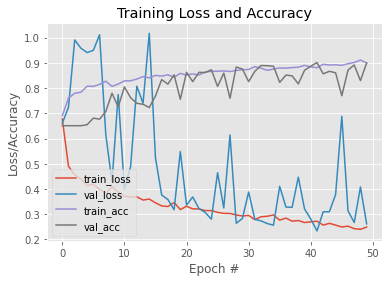

In [60]:
%matplotlib inline
#import matplotlib.pyplot as plt
#print(H.history["loss"])
#N = np.arange(0,  NUM_EPOCHS)
#print(N)
#plt.plot(N,H.history["loss"])
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0,  NUM_EPOCHS)
plt.style.use("ggplot")
fig = plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [0]:
fig.savefig('my_figure.png')

##Exploring Predictions

In [63]:
print(predictions.shape)
print(predictions[:1])

(1002, 2)
[[0.9663906  0.03360936]]


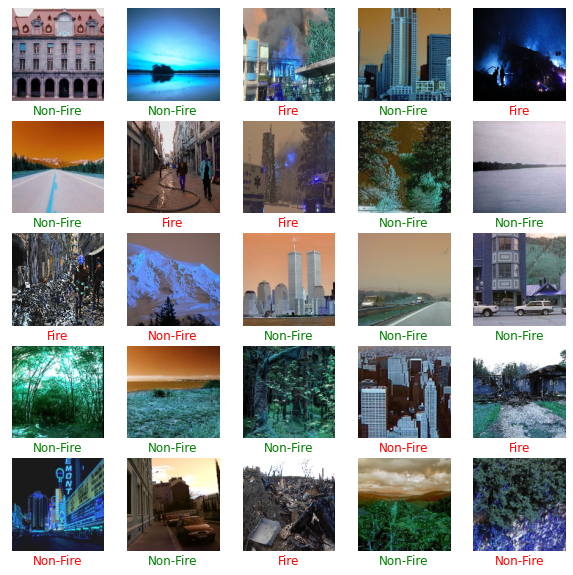

In [66]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i], cmap=plt.cm.binary)
    if testY[i][0] == 1:
      if predictions[i][0] > 0.5:
        plt.xlabel("Non-Fire", color='green')
      else:
        plt.xlabel("Non-Fire", color='red')
    else:
      if predictions[i][0] > 0.5:
        plt.xlabel("Fire", color='green')
      else:
        plt.xlabel("Fire", color='red')

plt.show()

In [0]:
MODEL_PATH = '/content/drive/My Drive/Colab Notebooks'
model.save( MODEL_PATH)

In [0]:
model.summary()